# Task solution

At the moment I would like to share my understanding of a task, as far as I understand the idea is to forecast a power and other features using given data, If I am correct and my solution suits you then we can proceed forward (extending the method for other features or having a meet)

## Approach
1. I read all cycles data for all hours folders and concatenated it in correct order.
2. I train a NLinear model because it wins in a lot of benchmarks on [Papers with code](https://paperswithcode.com/task/time-series-forecasting) and is conveniently implemented in darts Python module.
3. Below I present a results of a model forecast in comparison with real data.

In [2]:
import os

import darts
from darts.models.forecasting.nlinear import NLinearModel

import plotly.graph_objects as go
from IPython.display import Image

import pandas as pd

from utils import read_all_cycles, display_results, calculate_energy

# Disable some module messages
import logging
logging.disable(logging.CRITICAL) 

# Disable warnings
import warnings
warnings.filterwarnings("ignore")


DATA_FOLDER = os.path.join('.', 'output')
MODEL_FOLDER = os.path.join('.', 'models')

In [3]:
# This function reads all data
df_h = read_all_cycles(DATA_FOLDER)

# Reset the index, as each cycle df had it's own index, now it's a single index for all data
df_h = df_h.reset_index(drop=True)

# Use one sixth for validation, everyting else for training
split_point = int(5 / 6 * len(df_h))

In [4]:
# All features that we are forecasting
features = ['power', 'voltage', 'pressure_cathode_inlet']

# Create a dataset for each feature
datasets = {}
for feature in features:
    series = darts.TimeSeries.from_dataframe(df_h, value_cols=feature)
    datasets[feature] = series[:split_point], series[split_point:]

# I load pretrained model for each feature as I used separate file for training and it's not relevant atm
models = {
    feature: NLinearModel.load(os.path.join(MODEL_FOLDER, f'nlinear_full_data_{feature}_1024_512.pkl'))
    for feature in features
}


# The following are the results for each of the feature that we needed to forecast (power, voltage and pressure_cathode_inlet)

## All data chart

On the first chart for each feature you can see all available data and predictions, basically model only had data before the predictions started, so the task over here is to evaluate how much the predictions differ from the real data.

Basically the model isn't doing very well in a long term, also I present MAE metric.

## Small range forecast

Yet the model is much better at forecasting for a smaller range, as we can see the first 5,000 predictions look much better for each feature

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
MAE of power forecast is: 5.727314139162798


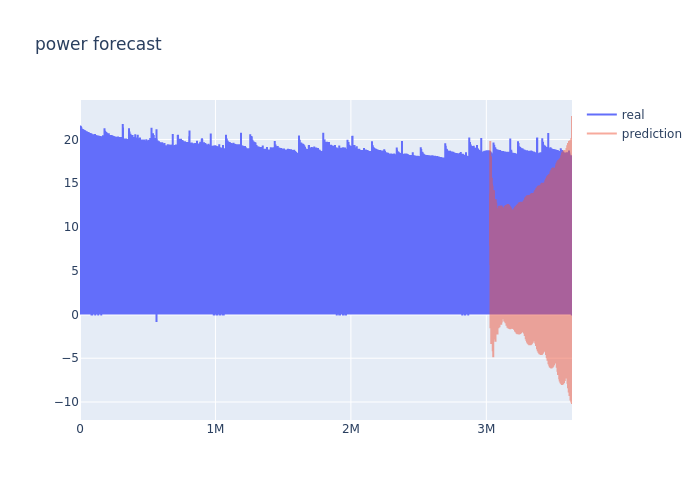

power forecast of a small range ahead
MAE of power forecast is: 5.727314139162798


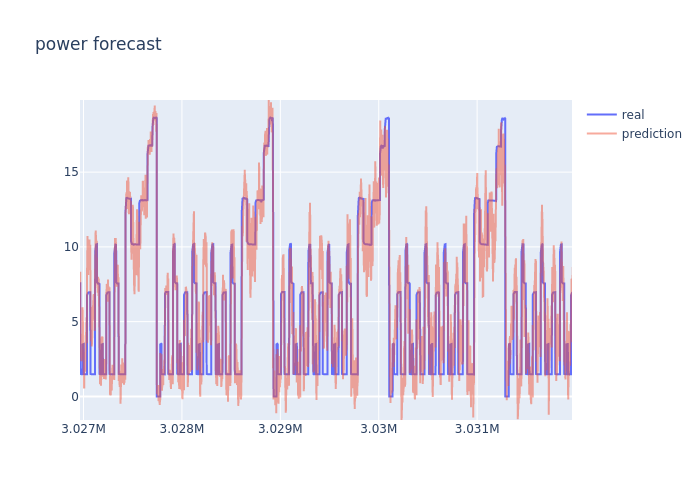

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]
MAE of voltage forecast is: 0.09003815126938072


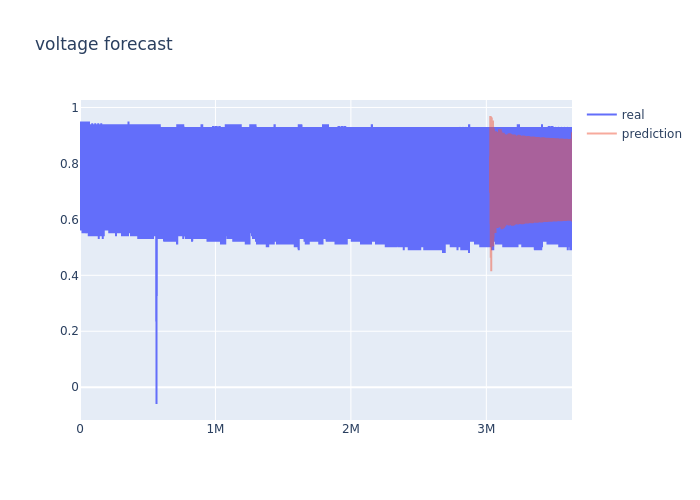

voltage forecast of a small range ahead
MAE of voltage forecast is: 0.09003815126938072


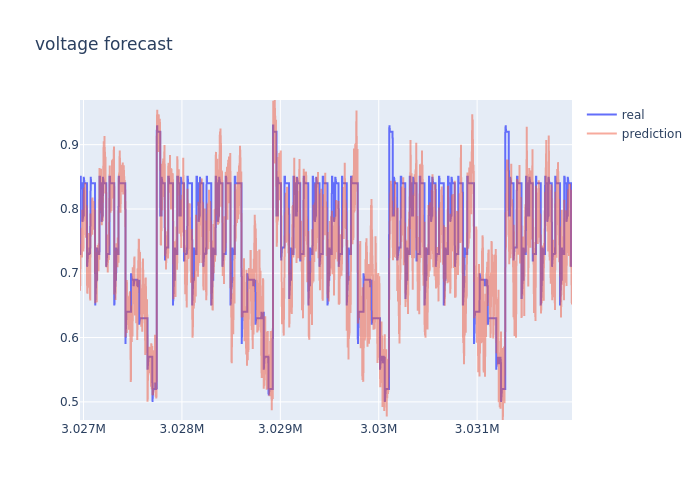

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]
MAE of pressure_cathode_inlet forecast is: 3616.416370517189


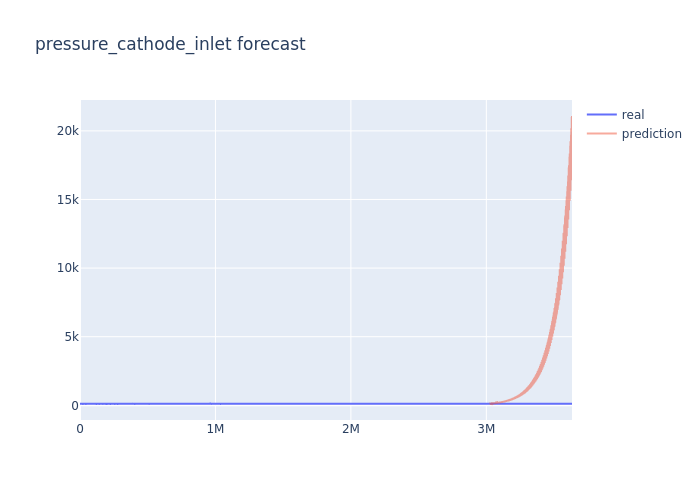

pressure_cathode_inlet forecast of a small range ahead
MAE of pressure_cathode_inlet forecast is: 3616.416370517189


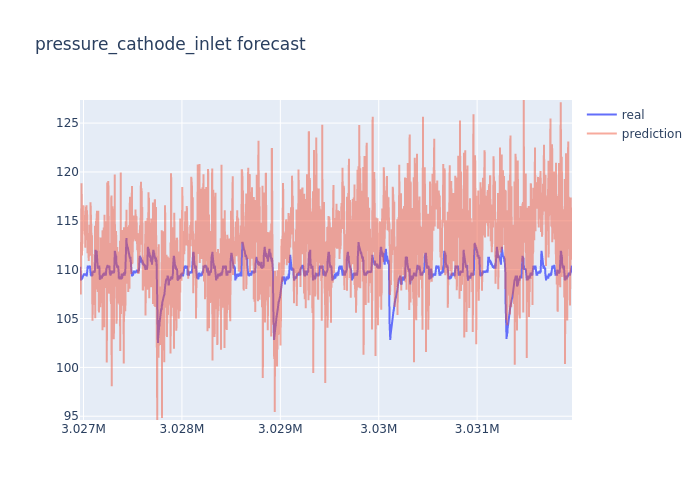

In [5]:
for feature in features:

    train, val = datasets[feature]

    predictions = models[feature].predict(len(val))

    display_results(
        df=df_h,
        feature=feature,
        prediction=predictions,
        val=val,
        train_len=len(train),
    )

    print(f'{feature} forecast of a small range ahead')

    display_results(
        df=df_h,
        feature=feature,
        prediction=predictions,
        val=val,
        train_len=len(train),
        max_len=5_000
    )

# Data forecast for a given cycle

Change values of `HOURS` and/or `cycle_id` to test this.

For each point in task the following approach is used:

1. Power forecast - forecast `power` for next cycle using pre-trained models and data of given cycle
2. Voltage forecast - forecast `voltage` for next cycle using pre-trained models and data of given cycle
3. Energy - calculate energy using `E = Pt` formula and calculating it using Simpson's rule to calculate area under curve.
4. Energy / cathode inlet - Divide calculated energy by a sum of forecasted `pressure_cathode_inlet`
5. Power / Cathode inlet - Divide each forecasted value of `power` by each forecasted value of `pressure_cathode_inlet` and plot the results.

Forecasted power for cycle 113 from 50_h
MAE of power forecast is: 0.9885310168904705


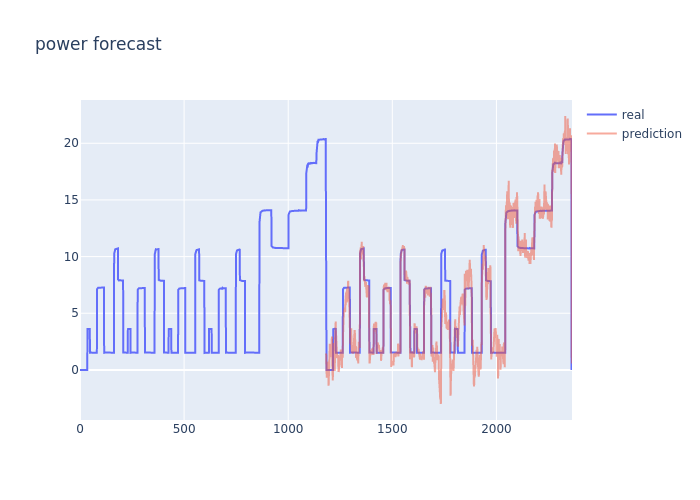

Forecasted voltage for cycle 113 from 50_h
MAE of voltage forecast is: 0.03005792222985909


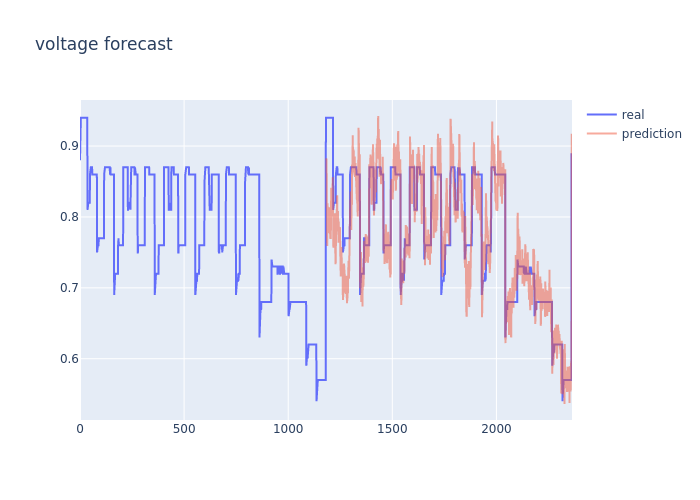

Calculate Energy:
Real - 919.4683333333332
predicted - 910.3222947084029


Calculate Energy / cathode inlet:
Real - 0.007095980531049131
predicted - 0.006959067773413445

Calculate Power / cathode inlet:
MAE of power / pressure_cathode_inlet forecast is: 0.005012014105762773


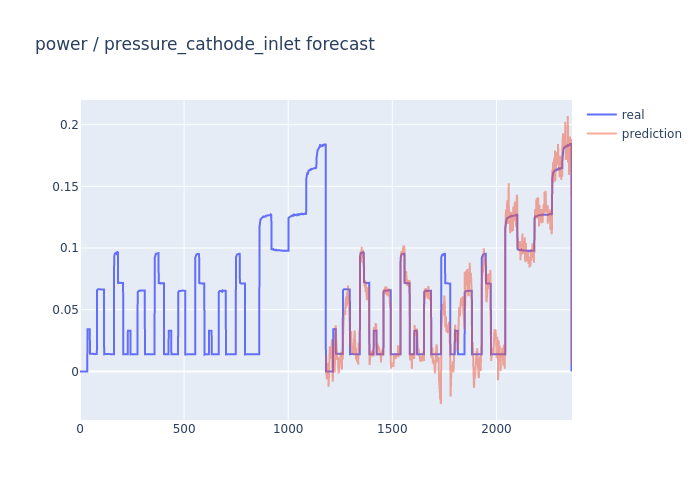

In [6]:
# Input Data
HOURS = '50_h'
cycle_id = 113

# Code that performs all calculations

# Read the cycle that user requested
cycle_df = pd.read_csv(
    os.path.join(DATA_FOLDER, HOURS, 'data', f'{HOURS}_cycle_{cycle_id}.csv')
).reset_index(drop=True)

# Read the next cycle and use it to validate model performance
next_cycle_df = pd.read_csv(
    os.path.join(DATA_FOLDER, HOURS, 'data', f'{HOURS}_cycle_{cycle_id + 1}.csv')
).reset_index(drop=True)
next_cycle_df.index = next_cycle_df.index + cycle_df.index.max()

# Concat both cycles into a single DataFrame for convenient usage in display function
both_cycles_df = pd.concat([cycle_df, next_cycle_df], ignore_index=True).reset_index(drop=True)

# Create TimeSeries from cycle data
series = darts.TimeSeries.from_dataframe(cycle_df, value_cols='power')
real = darts.TimeSeries.from_dataframe(next_cycle_df, value_cols='power')

# Predict power
predictions_power = models['power'].predict(len(series), series=series, verbose=False)

print(f'Forecasted power for cycle {cycle_id} from {HOURS}')

display_results(both_cycles_df, 'power', predictions_power, real, len(series))

# Create TimeSeries from cycle data
series = darts.TimeSeries.from_dataframe(cycle_df, value_cols='voltage')
real = darts.TimeSeries.from_dataframe(next_cycle_df, value_cols='voltage')

# Predict voltage
predictions_voltage = models['voltage'].predict(len(series), series=series, verbose=False)

print(f'Forecasted voltage for cycle {cycle_id} from {HOURS}')

display_results(both_cycles_df, 'voltage', predictions_voltage, real, len(series))

# Calculate real and predicted energy
real_energy = calculate_energy(next_cycle_df["voltage"])
predicted_energy = calculate_energy(predictions_voltage.values().squeeze())

print('Calculate Energy:')
print(f'Real - {real_energy}')
print(f'predicted - {predicted_energy}')
print()

# Create TimeSeries from cycle data
series = darts.TimeSeries.from_dataframe(cycle_df, value_cols='pressure_cathode_inlet')
real = darts.TimeSeries.from_dataframe(next_cycle_df, value_cols='pressure_cathode_inlet')

# Predict pressure_cathode_inlet
predictions_cathode = models['pressure_cathode_inlet'].predict(len(series), series=series, verbose=False)

print()
print('Calculate Energy / cathode inlet:')
print(f'Real - {real_energy / next_cycle_df["pressure_cathode_inlet"].sum()}')
print(f'predicted - {predicted_energy / predictions_cathode.values().squeeze().sum()}')

print()
print('Calculate Power / cathode inlet:')
both_cycles_df['power / pressure_cathode_inlet'] = both_cycles_df['power'] / both_cycles_df['pressure_cathode_inlet']
real = darts.TimeSeries.from_series(next_cycle_df['power'] / next_cycle_df['pressure_cathode_inlet'])
predicted = darts.TimeSeries.from_series(predictions_power.values().squeeze() / predictions_cathode.values().squeeze())

display_results(both_cycles_df, 'power / pressure_cathode_inlet', predicted, real, len(series))